In [2]:
import pandas as pd
import numpy as np
from pandas.core.interchange.from_dataframe import categorical_column_to_series
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
chunk_size = 100000

In [ ]:
# Initialize variables for analysis
total_rows = 0
column_sums = None
column_squared_sums = None

In [ ]:
# Step 3: Read the data in chunks
def read_csv_in_chunks(file_path, chunk_size):
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        yield chunk

In [ ]:
# Step 4: Sample 20% of observation
labels = pd.read_csv('data/train_labels.csv')
sample_labels = labels.sample(frac=0.2, random_state=42)

In [ ]:
# Read data
sampled_data = []
for chunk in read_csv_in_chunks('data/train_data.csv', chunk_size):
    merged_chunk = pd.merge(chunk, sample_labels, on='customer_ID', how='inner')
    sampled_data.append(merged_chunk)

# Combine all chunks into a single dataframe
development_sample = pd.concat(sampled_data, ignore_index=True)

# Save the development sample
development_sample.to_csv('data/development_sample.csv', index=False)

In [ ]:
# load development_sample
data = []
for chunk in read_csv_in_chunks('data/development_sample.csv', chunk_size):
    data.append(chunk)



In [ ]:
df = pd.concat(data, ignore_index=True)
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [ ]:
# Step 5: One-hot encoding for categorical variables
# List of known categorical columns
# List of categorical columns
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# Function to read and process data in chunks
def process_chunks(file_path, chunk_size=100000):
    encoded_chunks = []

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert all specified columns to strings
        for col in categorical_columns:
            chunk[col] = chunk[col].astype(str)

        # Perform one-hot encoding
        encoded_chunk = pd.get_dummies(chunk, columns=categorical_columns)

        # Ensure the encoded columns are of type int (0 or 1)
        for col in encoded_chunk.columns:
            if col.startswith(tuple(categorical_columns)):
                encoded_chunk[col] = encoded_chunk[col].astype(int)

        encoded_chunks.append(encoded_chunk)

        print(f"Processed chunk of size {len(chunk)}")

    return pd.concat(encoded_chunks, ignore_index=True)

# Process the file
df_encoded = process_chunks('data/development_sample.csv')

print("One-hot encoding completed.")
print(f"Shape of encoded DataFrame: {df_encoded.shape}")

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())

# Check the data types of the encoded columns
print(df_encoded.dtypes)

Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 7082
One-hot encoding completed.
Shape of encoded DataFrame: (1107082, 235)
                                         customer_ID         S_2       P_2  \
0  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-03-11  0.374606   
1  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-04-22  0.414269   
2  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-05-12  0.413310   
3  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-06-10  0.328983   
4  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-07-19  0.496989   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.03351

In [ ]:
df_encoded.to_csv('data/train_encoded_data.csv', index=False)

***USE THE BELOW CODE FOR QUESTION 6~***

In [ ]:
# Step 6: EDA
df = pd.read_csv('data/train_encoded_data.csv')


In [ ]:
df['S_2'] = pd.to_datetime(df['S_2'])

In [ ]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,0,1,0,0,0,0,0,0,0,1
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,0,1,0,0,0,0,0,0,0,1
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,0,1,0,0,1,0,0,0,0,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,0,1,0,0,1,0,0,0,0,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,0,1,0,0,1,0,0,0,0,0


In [ ]:
# calculate last 6 months average value for numerical columns
def calculate_average_last_6_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=6)

    # Filter data for the last 6 months
    last_6_months_data = df[(df['S_2'] >= start_date) & (df['S_2'] <= end_date)]

    # Calculate the average for each numerical column
    averages = last_6_months_data.mean(numeric_only=True)
    return averages

# calculate last 12 months average value for numerical columns
def calculate_average_last_12_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=12)
    last_12_months_data = df[df['S_2'] >= start_date]
    averages = last_12_months_data.mean(numeric_only=True)
    return averages

# calculate last 6 months minimum value for numerical columns
def calculate_min_last_6_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=6)
    last_6_months_data = df[(df['S_2'] >= start_date) & (df['S_2'] <= end_date)]
    minimums = last_6_months_data.min(numeric_only=True)
    return minimums

# calculate last 9 months maximum value for numerical columns
def calculate_max_last_9_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=9)
    last_9_months_data = df[(df['S_2'] >= start_date) & (df['S_2'] <= end_date)]
    maximums = last_9_months_data.max(numeric_only=True)
    return maximums

# calculate last 3 months total value for numerical columns
def calculate_sum_of_3_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=3)
    last_3_months_data = df[(df['S_2'] >= start_date) & (df['S_2'] <= end_date)]
    sums = last_3_months_data.sum(numeric_only=True)
    return sums

In [ ]:
eda_df = df.copy()

In [ ]:
# Remove one-hot encoding variables
drop_prefixes = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

regex_pattern = '^(' + '|'.join(drop_prefixes) + ')'

eda_df = eda_df.drop(columns=eda_df.filter(regex=regex_pattern).columns)

In [ ]:
# Average of last 6 months
average_6_values = calculate_average_last_6_months(eda_df)

new_column_names = {col: f"{col}_Ave_6" for col in average_6_values.index if col!= 'customer_ID'}

average_6_values = average_6_values.rename(index=new_column_names)

average_6_values

P_2_Ave_6       0.645674
D_39_Ave_6      0.167517
B_1_Ave_6       0.132256
B_2_Ave_6       0.604573
R_1_Ave_6       0.093123
                  ...   
D_142_Ave_6     0.391815
D_143_Ave_6     0.179578
D_144_Ave_6     0.051805
D_145_Ave_6     0.063218
target_Ave_6    0.253945
Length: 178, dtype: float64

In [ ]:
# Average of last 12 months
average_12_values = calculate_average_last_12_months(eda_df)

new_column_names = {col: f"{col}_Ave_12" for col in average_12_values.index if col!= 'customer_ID'}

average_12_values = average_12_values.rename(index=new_column_names)

average_12_values

P_2_Ave_12       0.655332
D_39_Ave_12      0.154940
B_1_Ave_12       0.124777
B_2_Ave_12       0.620399
R_1_Ave_12       0.080536
                   ...   
D_142_Ave_12     0.390749
D_143_Ave_12     0.178400
D_144_Ave_12     0.052090
D_145_Ave_12     0.062331
target_Ave_12    0.247798
Length: 178, dtype: float64

In [ ]:
# Calculate minimum value
min_6_values = calculate_min_last_6_months(eda_df)

new_column_names = {col: f"{col}_min_6" for col in min_6_values.index if col!= 'customer_ID'}

min_6_values = min_6_values.rename(index=new_column_names)

min_6_values


P_2_min_6      -4.205811e-01
D_39_min_6      9.052854e-09
B_1_min_6      -8.993963e-01
B_2_min_6       5.485064e-08
R_1_min_6       1.065542e-08
                    ...     
D_142_min_6    -1.422761e-02
D_143_min_6     2.565179e-08
D_144_min_6     4.701217e-09
D_145_min_6     2.811854e-09
target_min_6    0.000000e+00
Length: 178, dtype: float64

In [ ]:
# Calculate maximum value
max_9_values = calculate_max_last_9_months(eda_df)

new_column_names = {col: f"{col}_max_9" for col in max_9_values.index if col!= 'customer_ID'}

max_9_values = max_9_values.rename(index=new_column_names)

max_9_values

P_2_max_9       1.010000
D_39_max_9      5.268649
B_1_max_9       1.324059
B_2_max_9       1.010000
R_1_max_9       3.006102
                  ...   
D_142_max_9     2.091407
D_143_max_9     1.010000
D_144_max_9     1.343331
D_145_max_9     4.827630
target_max_9    1.000000
Length: 178, dtype: float64

In [ ]:
# Calculate total value
sum_3_values = calculate_sum_of_3_months(eda_df)

new_column_names = {col: f"{col}_sum_3" for col in sum_3_values.index if col!= 'customer_ID'}

sum_3_values = sum_3_values.rename(index=new_column_names)

sum_3_values

P_2_sum_3       173460.410369
D_39_sum_3       50358.957004
B_1_sum_3        37254.089682
B_2_sum_3       163096.167642
R_1_sum_3        27327.040214
                    ...      
D_142_sum_3      18441.322821
D_143_sum_3      48197.847675
D_144_sum_3      14054.392180
D_145_sum_3      17013.017700
target_sum_3     69922.000000
Length: 178, dtype: float64

In [ ]:
# Prepare dataset for comparison between March 2018 and March 2017
march_2018_data = eda_df[(eda_df['S_2'].dt.year == 2018) & (eda_df['S_2'].dt.month == 3)]
march_2017_data = eda_df[(eda_df['S_2'].dt.year == 2017) & (eda_df['S_2'].dt.month == 3)]

In [ ]:
# Calculate the comparison between March 2018 and March 2017
comparison = (march_2018_data.mean(numeric_only=True) - march_2017_data.mean(numeric_only=True))/march_2017_data.mean(numeric_only=True)
comparison

P_2      -0.056293
D_39      0.528884
B_1       0.276471
B_2      -0.082016
R_1       0.817759
            ...   
D_142     0.023210
D_143     0.023819
D_144    -0.032226
D_145     0.052246
target    0.116875
Length: 178, dtype: float64

In [ ]:
# Aggregation for categorical variables

#Percentage of times column equals 1 in last six months
def percentage_times_equals1_last_6_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=6)
    
    # Filter data for the last 6 months
    response_rate_data = df[(df['S_2'] >= start_date) & (df['S_2'] <= end_date)]
    
    # Calculate the average for each column
    response_rate = response_rate_data.mean(numeric_only=True)
    return response_rate

#Whether the column is response at least once in the last 12 months
def ever_response_in_last_12_months(df):
    end_date = df['S_2'].max()
    start_date = end_date - pd.DateOffset(months=12)
    last_12_months_data = df[df['S_2'] >= start_date]
     # Check if there was any response in the specified column
    ever_response = last_12_months_data.max(numeric_only=True)
    return ever_response
# Return 1 for yes, 0 for no


In [ ]:
keep_prefixes = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
regex_pattern = '^(' + '|'.join(keep_prefixes) + ')'

columns_to_keep = df.filter(regex=regex_pattern).columns.tolist() + ['S_2']

# Create the final DataFrame with the data in those columns
categorical_df = df[['customer_ID'] + columns_to_keep]
categorical_df


In [ ]:
# Percentage times column value equals 1 in 6 months
percent_6_values = percentage_times_equals1_last_6_months(categorical_df)

new_col_names = {col: f"{col}_Response_rate_6" for col in percent_6_values.index if col!= 'customer_ID'}

percent_6_values = percent_6_values.rename(index=new_col_names)

percent_6_values


In [ ]:
#Check whether the column is response atleast once in 12 months
ever_response_12 = ever_response_in_last_12_months(categorical_df)
new_names = {col: f"{col}_Ever_Response_12" for col in ever_response_12.index if col!= 'customer_ID'}
ever_response_12 = ever_response_12.rename(index=new_names)
ever_response_12
#Here 1 represents that there is response at least once in the period of 12 months

In [ ]:
# Step 7; Train-test split
# Use a random seed of 42 for the split.
# Split the data into features and target
X = df.drop(columns=['customer_ID', 'target', 'S_2'])
y = df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [ ]:
# save train and test data as csv
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
X_test1.to_csv('data/X_test1.csv', index=False)
y_test1.to_csv('data/y_test1.csv', index=False)
X_test2.to_csv('data/X_test2.csv', index=False)
y_test2.to_csv('data/y_test2.csv', index=False)

Feature importance:
[2.18087077e-01 5.80002693e-03 7.01190904e-02 1.66131146e-02
 3.16168219e-02 1.60705727e-02 1.13943955e-02 1.83439162e-02
 1.69350654e-02 6.40974240e-03 1.17567312e-02 6.40614191e-03
 8.36995151e-03 5.74957673e-03 3.57504049e-03 6.42198324e-03
 2.64185527e-03 1.39091285e-02 5.48653817e-03 7.55468383e-03
 1.13953361e-02 3.49054439e-03 4.20104153e-03 1.30788228e-02
 3.82661931e-02 1.34419948e-02 3.29990010e-03 5.54459635e-03
 8.02922528e-03 2.60301144e-03 3.61162401e-03 5.30780898e-03
 1.21105846e-03 3.72448633e-03 3.06269131e-03 3.33538791e-03
 2.12789234e-03 1.96687947e-03 2.11729389e-03 3.70361423e-03
 1.88608770e-03 3.44649306e-03 1.90379308e-03 3.22535262e-03
 3.11541068e-03 2.41571432e-03 2.07867939e-03 1.46089692e-03
 1.86205003e-03 2.30584550e-03 4.41596983e-03 1.02899503e-03
 3.73124331e-03 2.81671411e-03 1.92902901e-03 2.64791399e-03
 3.46174254e-03 2.17870809e-03 1.01444346e-03 7.68099213e-04
 2.66078510e-03 2.00782856e-03 5.89690078e-03 2.15349882e-03
 1.8

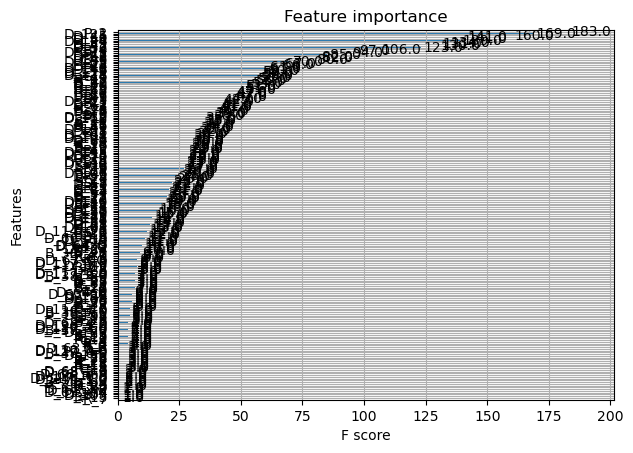

In [ ]:
# Step 8: Calculate feature importance using XGBoost

# Load the training data
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train)

# Plot the feature importance
plot_importance(xgb_model)

# Save the feature importance
feature_importance = xgb_model.feature_importances_
np.save('feature_importance.npy', feature_importance)

# Display the feature importance
print("Feature importance:")
print(feature_importance)

In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
feature_importance_df.to_csv('data/feature_importance.csv', index=False)

In [ ]:
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.005]
important_features

,Feature,Importance
0,P_2,0.218087
2,B_1,0.070119
24,B_9,0.038266
4,R_1,0.031617
7,B_3,0.018344
8,D_42,0.016935
3,B_2,0.016613
5,S_3,0.016071
17,D_48,0.013909
25,R_3,0.013442


In [ ]:
# Apply only importamt features
# Run default XBG
X_train_important = X_train[important_features['Feature']]

xgb_model.fit(X_train_important, y_train)

feature_importance_important = xgb_model.feature_importances_

feature_importance_important_df = pd.DataFrame({
    'Feature': X_train_important.columns,
    'Importance': feature_importance_important
})
feature_importance_important_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_important_df


,Feature,Importance
0,P_2,0.218087
2,B_1,0.070119
24,B_9,0.038266
4,R_1,0.031617
7,B_3,0.018344
...,...,...
230,D_68_6.0,0.000000
101,D_87,0.000000
224,D_68_0.0,0.000000
225,D_68_1.0,0.000000


In [ ]:
feature_importance_important_df = feature_importance_important_df[feature_importance_important_df['Importance'] > 0.005]
feature_importance_important_df.to_csv('data/feature_importance_important.csv', index=False)

In [ ]:
# Run XGB applying parameters 300 trees, 0.5 as learning rate, maximum depth of trees is 4, uses 50% of observation to build each tree, uses 50% of features to build each tree, and assigns a weight of 5 to default observations.
# Save the model as 'xgb_model_important_features'
# Initialize the XGBClassifier
xgb_model_important_features = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=4,
    learning_rate=0.5,
    n_estimators=300,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# Apply only important features calculated by default XGB
X_train_featured = X_train_important[feature_importance_important_df['Feature']]

# Create sample weights
sample_weights = np.where(y_train['target'] == 1, 5, 1)

# Fit the model
xgb_model_important_features.fit(X_train_featured, y_train, sample_weight=sample_weights)

# Calculate the feature importance
feature_importance_parameter_model = xgb_model_important_features.feature_importances_



In [ ]:
# Save the feature importance
feature_importance_parameter_model_df = pd.DataFrame({
    'Feature': X_train_important.columns,
    'Importance': feature_importance_parameter_model
})
feature_importance_parameter_model_df = feature_importance_parameter_model_df.sort_values(by='Importance', ascending=False)

feature_importance_parameter_model_df = feature_importance_parameter_model_df[feature_importance_parameter_model_df['Importance'] > 0.005]

feature_importance_parameter_model_df.to_csv('data/feature_importance_parameter_model.csv', index=False)

feature_importance_parameter_model_df

,Feature,Importance
0,P_2,0.250095
12,B_7,0.124635
16,B_38_2.0,0.091958
11,D_44,0.057968
5,D_42,0.034543
2,B_9,0.033858
17,D_45,0.029030
26,B_22,0.028504
7,S_3,0.025349
4,B_3,0.024330


In [3]:
### ONLY FOR GOOGLE COLAB
# Load the training data
X_train = pd.read_csv('/content/drive/MyDrive/ML -fall24/project/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/ML -fall24/project/y_train.csv')
feature_importance_parameter_model_df = pd.read_csv('/content/drive/MyDrive/ML -fall24/project/feature_importance_parameter_model.csv')

In [ ]:
# step 9: grid search

# Load the training data, applying important features calculated by step 8
X_train_step_9 = X_train[feature_importance_parameter_model_df['Feature']]
# y_train = pd.read_csv('data/y_train.csv')

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier()

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 300],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Save the best parameters
np.save('best_params.npy', best_params)

# Display the best parameters
print("Best parameters:")
print(best_params)



Fitting 3 folds for each of 72 candidates, totalling 216 fits
